# HW5.1 text classification with logistic regression. 

We will use the same dataset Triage as last time. Here is what's in this assignment: 

1. we will explore several options of how to convert text to vectors to be fed into a logistic regression classifier using sklearn. 
2. we will implement and train a logistic regression classifier using Python (no sklearn!).
3. we will compare the text classification result with those you got from the NB last week. 

## PART I: text input representation: converting text to vectors

There are many ways to convert text to vectors. Let's try two ways in this assignment. 

1. Count vectors 

Read the documentation for sklearn ```CountVectorizer``` here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform 

2. Normalized counts - tfidf

Read the documentation for sklearn ```tfidfVectorizer``` here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Make sure you understood the code examples for those two vectorizers. 



### logistic regression with unigram count vectors


In [26]:
# This example shows how to convert text to Count vectors. When you use get_feature_names_out() function,
# you can see which position of the vector correspond to which word in the vocabulary. 
# but usually we don't need to pay too much attention to that. 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document',
          'how about these documents']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())

print(X.toarray())

# I CREATED THE UNIGRAM VECTORS FOR LOGISTIC RERESSION WITH UNIGRAM COUNT VECTORS AT THE BOTTOM OF THE PAGE
# IN ORDER FOR IT TO BE IN THE SAME STYLE AS ALL THE OTHER VECTORS. IT IS RIGHT ABOVE THE "WRAPPING UP"
# SECTION AT THE BOTTOM.

['about' 'and' 'document' 'documents' 'first' 'how' 'is' 'one' 'second'
 'the' 'these' 'third' 'this']
[[0 0 1 0 1 0 1 0 0 1 0 0 1]
 [0 0 2 0 0 0 1 0 1 1 0 0 1]
 [0 1 0 0 0 0 1 1 0 1 0 1 1]
 [0 0 1 0 1 0 1 0 0 1 0 0 1]
 [1 0 0 1 0 1 0 0 0 0 1 0 0]]


#### you turn: read the Triage dataset using the same loader from last time, and convert your text documents into a count vector. 

In [27]:
# similar to the example above, your document 
from util import load_data, Dataset, Example
import numpy as np
dataset = load_data("./data/triage")


def get_data(split:list[Example])->(list[str],list[int]):
    """
    massage the data into a format consistent with the input type required by CountVectorizer or tfidfVectorizer. 

    args 
        split: pass in the split, which should be either dataset.train or dataset.dev

    returns: 
        text: list of sentences
        labels: list of labels  

    """
    text = [' '.join(example.words) for example in split]
    labels = [example.label for example in split]
    return text, labels
    

# Load data using get_data
train_text, train_label = get_data(dataset.train)
dev_text, dev_label = get_data(dataset.dev)

#### load the data using get_data() and then convert them into count vector
```
train_text, train_label = get_data(dataset.train)
dev_text, dev_label = get_data(dataset.dev)
```

#### IMPORTANT note: 
You need to transform both train and dev data into a vector before feeding them into a classifier. But ```fit_transform()``` is a composition of two functions: fit and transform. 
You should use ```fit_transform()``` to fit the vector to your train text and transform it to the vector,
but when you deal with the dev text, you don't need to fit the Vectorizer any more, you just need to use the 
Vectorizer you fit on the train data, and simply ```transform()``` it. Don't use ```fit_transform()``` on both data splits. 
To confirm that you are using the same Vectorizer for both train data and test data, you should get the feature names out
and see that they have the same length. 
e.g., : 

```
names=vectorizer.get_feature_names_out()
print(len(names))
```

Because the train and dev split have different vocabulary sizes, if you ```fit_transform``` on each of them you will end up with vectors of different lengths. Since your classifier is trained with the input vector length from train, it should not take input with a different vector length on the dev data. 

In [28]:
# YOUR CODE HERE to convert both train and dev data into Count vectors

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train_text)

X_dev = vectorizer.transform(dev_text)

names = vectorizer.get_feature_names_out()
print(len(names))



31211


## logistic regression with bigram count vectors

When using the CountVectorizer, you can also use bigram or Ngram counts. If you read the documentation for  ```CountVectorizer``` above, you will find the argument called ```ngram_range```. Try to use both unigrams and bigrams for this task. 

In [29]:
# Code to apply CountVectorizer using unigrams and bigrams
# YOUR CODE HERE

vectorizer_bigram = CountVectorizer(ngram_range=(1, 2))
X_train_bigram = vectorizer_bigram.fit_transform(train_text)
X_dev_bigram = vectorizer_bigram.transform(dev_text)

In [30]:
# Refer to the tfidfVectorizer linked above to transform the text into tfidf vectors
# YOUR CODE HERE

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_text)
X_dev_tfidf = tfidf_vectorizer.transform(dev_text)


# After you have transformed your text (train and dev) into tfidf vectors, try to get the names of 
# the vector elements at each position and print out the length of the vector. Inspect the names of
# the vectors from different portions of the vector. What do you see in the vocabulary?

feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Length of TF-IDF vector: {len(feature_names)}")
print("First 10 words/bigrams:", feature_names[:10])
print("Last 10 words/bigrams:", feature_names[-10:])

Length of TF-IDF vector: 31211
First 10 words/bigrams: ['00' '000' '0000' '000ha' '000l' '000lt' '000m2' '000rmb' '004' '00h58']
Last 10 words/bigrams: ['état' 'été' 'ötanos' 'üan' 'üaram' 'üei' 'ühurricane' 'ülol' 'üthe'
 'üthis']


The vocabulary looks a little strange. I think because there is a mix of language in the text (english and french), it is struggling with the accents. Additionally, there are numbers in the data which is making the words look strange.

## logistic regression with tfidf vectors

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# create train and test sets. train_label and dev_label was created above.
# the Xtrain and Xtest should be the result variable of passing the train_text and dev_text through the vectorizer. 

Xtrain, Xtest = X_train_tfidf, X_dev_tfidf
Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

# PART II: Logistic regression from scratch

We have seen in class there are four components in a standard linear classifier: features (input), forward pass (function to compute p(Y|X)), a loss function (to measure the errors the system makes), and the optimizer/iterative learning process to adjust the weights to minimize the errors. We've already taken care of the input features above. Let's now implement the rest of the components. Let's use the tfidf vectors for this implemetation.

Recipe: 
```
   1. Initialize the parameters
Repeat {
   2. Make a prediction y_hat
   3. Calculate loss function
   4. Get gradient for loss function
   5. Update parameters W, b
 }
```

In [32]:
# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# make predictions
def sigmoid(z):
    """
    sigmoid function
    
    args
        z: the result of linear computation, z = X.dot(W) + b
    """
    
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))
    

def forward(X, W, b):
    """
    forward pass, return the result of passing X.dot(W)+b through sigmoid function

    args
        X: input features
        W: weights
        b: biases
    """
    return sigmoid(X.dot(W) + b)

# calculate the accuracy
def classification_rate(Y, Y_HAT):
    return np.mean(Y == Y_HAT)

# cross entropy
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY) + (1 - T)*np.log(1 - pY))

# train loop


# use these lists to store the loss values during the training, so you can visualize them later in a curve
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights
for i in range(num_iter):
    # Forward pass
    p_Ytrain = forward(Xtrain, W, b)
    p_Ytest = forward(Xtest, W, b)
    
    # Loss computation
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))
    
    # Gradient computation
    # dw = (1 / Xtrain.shape[0]) * np.dot(Xtrain.T, (p_Ytrain - Ytrain).T)
    # db = (1 / Xtrain.shape[0]) * np.sum(p_Ytrain - Ytrain)
    dw = Xtrain.T.dot(p_Ytrain - Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    
    # Weights update
    W -= learning_rate * dw
    b -= learning_rate * db

Final train classification_rate: 0.9347619500142544
Final test classification_rate: 0.7629226583754373


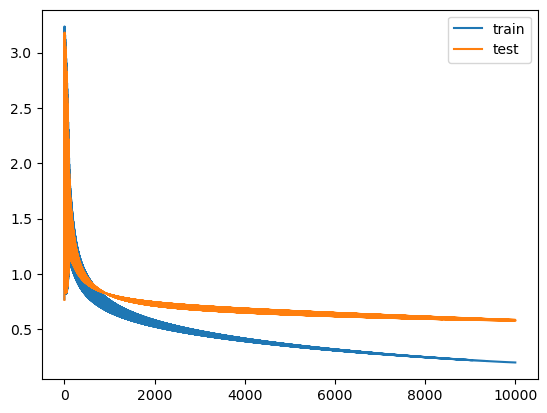

In [33]:
# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification_rate:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate:", classification_rate(Ytest, np.round(p_Ytest)))

# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

# PART III: compare different vectors

Now substitute the tfidf vectors with the unigram, and unigram+bigram count vectors. Train the model again. How is the accuracy this time?

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# create train and test sets. train_label and dev_label was created above.
# the Xtrain and Xtest should be the result variable of passing the train_text and dev_text through the vectorizer. 

Xtrain, Xtest = X_train_bigram, X_dev_bigram
Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# make predictions
def sigmoid(z):
    """
    sigmoid function
    
    args
        z: the result of linear computation, z = X.dot(W) + b
    """
    
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))
    

def forward(X, W, b):
    """
    forward pass, return the result of passing X.dot(W)+b through sigmoid function

    args
        X: input features
        W: weights
        b: biases
    """
    return sigmoid(X.dot(W) + b)

# calculate the accuracy
def classification_rate(Y, Y_HAT):
    return np.mean(Y == Y_HAT)

# cross entropy
def cross_entropy(T, pY):
    pY = np.clip(pY, 1e-10, 1-1e-10)
    return -np.mean(T*np.log(pY) + (1 - T)*np.log(1 - pY))

# train loop


# use these lists to store the loss values during the training, so you can visualize them later in a curve
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights
for i in range(num_iter):
    # Forward pass
    p_Ytrain = forward(Xtrain, W, b)
    p_Ytest = forward(Xtest, W, b)
    
    # Loss computation
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))
    
    # Gradient computation
    # dw = (1 / Xtrain.shape[0]) * np.dot(Xtrain.T, (p_Ytrain - Ytrain).T)
    # db = (1 / Xtrain.shape[0]) * np.sum(p_Ytrain - Ytrain)
    dw = Xtrain.T.dot(p_Ytrain - Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    
    # Weights update
    W -= learning_rate * dw
    b -= learning_rate * db

Final train classification_rate: 0.9992872754917799
Final test classification_rate: 0.7469879518072289


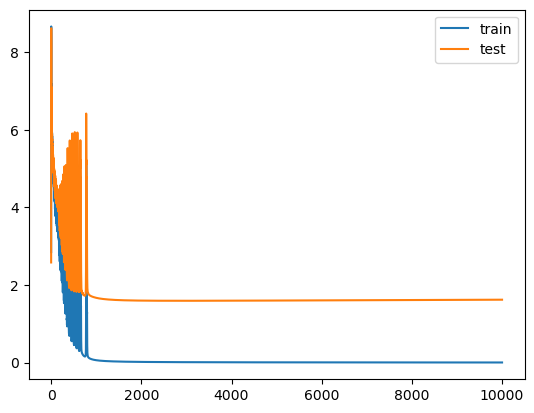

In [35]:
# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification_rate:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate:", classification_rate(Ytest, np.round(p_Ytest)))

# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

In [36]:
# unigram only
vectorizer_unigram = CountVectorizer(ngram_range=(1, 1))
X_train_unigram = vectorizer_unigram.fit_transform(train_text)
X_dev_unigram = vectorizer_unigram.transform(dev_text)

# create train and test sets. train_label and dev_label was created above.
# the Xtrain and Xtest should be the result variable of passing the train_text and dev_text through the vectorizer. 

Xtrain, Xtest = X_train_unigram, X_dev_unigram
Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# make predictions
def sigmoid(z):
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))

def forward(X, W, b):
    return sigmoid(X.dot(W) + b)

# calculate the accuracy
def classification_rate(Y, Y_HAT):
    return np.mean(Y == Y_HAT)

# cross entropy
def cross_entropy(T, pY):
    pY = np.clip(pY, 1e-10, 1-1e-10)
    return -np.mean(T*np.log(pY) + (1 - T)*np.log(1 - pY))

# train loop

# use these lists to store the loss values during the training, so you can visualize them later in a curve
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights
for i in range(num_iter):
    # Forward pass
    p_Ytrain = forward(Xtrain, W, b)
    p_Ytest = forward(Xtest, W, b)
    
    # Loss computation
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))
    
    # Gradient computation
    dw = Xtrain.T.dot(p_Ytrain - Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    
    # Weights update
    W -= learning_rate * dw
    b -= learning_rate * db

Final train classification_rate: 0.9750546422122969
Final test classification_rate: 0.735328410415857


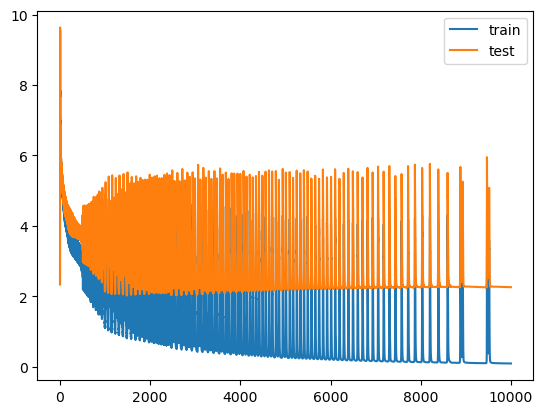

In [37]:
# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification_rate:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate:", classification_rate(Ytest, np.round(p_Ytest)))

# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

# wrapping up

You should see your training curve on your train data and dev data above. What do you observe? 

How does your final train and dev accuracy compare to using NaiveBayes model from last week?

NaiveBayes model data: 
dev accuracy 0.7329965021375826
train accuracy 0.82946878266654

Logistic Regression model data:

Using TFIDF
Final train classification_rate: 0.9338591656371757
Final test classification_rate: 0.759813447337738

Using unigram+bigram vectors
Final train classification_rate: 0.9992872754917799
Final test classification_rate: 0.743101438010105

Using only unigram vectors
Final train classification_rate: 0.9753397320155849
Final test classification_rate: 0.7271667314418966

For clarity, the graphs shown in this homework are training curves. The y-axis represents the loss value while the x-axis reprsents the epochs (iterations during training).

In the first graph (TFIDF), you can observe a sharp decline in loss value for both the training and testing dataset after the first epochs. After more epochs, the loss value begins to plateau for both the training and testing data. This makes sense, as the rapid decline in the beginning indicates the model is learning and adapting to the data. Plateauing of the test data can mean the beginning of overfitting for the training data. 

In the second graph (unigram+bigram), you can observe a more gradual decline in loss value. It almost approaches 0, which can indicate the start of overfitting to the training data. The dev set loss decreases at a slower rate than the TFIDF graph dev loss, and levels off after a certain number of epochs.

In the third graph (unigram), there is an even more gradual decline in loss value. Although it approaches 0, it varies in loss value greatly and for many epochs before plateauing. Similar to the unigram+bigram model, the dev loss set decreases at a slower rate than the TFIDF graph dev loss.

For all graphs, it makes sense for loss to drop after the first few epochs as the model learns rapidly about the data, then levels off as overfitting on the training data begins. It also makes sense for the training data have less loss than the testing data, because the model is trained off the training data and so would fit it better. 

In comparison to the NaivesBayes model, the logistic regression model with unigram+bigram and TFIDF perform better. They both have a higher train and test classification rate than the NaiveBayes model. Logistic regression with TFIDF shows an improvement on the dev set compared to the NaiveBayes model with an accuracy of 0.73 vs. 0.76. Logistic regression with unigram+bigram has a much better training accuracy of 0.99, but has a dev accuracy of 0.74 which is quite similar to the dev accuracy of the NaivesBayes model which is 0.73. The logistic regression model with only unigrams however, does not perform as well. The only unigram training classification rate is high, at 0.97. However, it's final test classficiation rate is at 0.72, which is lower than the test classfication rate of all other models, including the naivebayes model.

In summary, it would appear that out of the four models we've tried so far, logistic regression with TFIDF performs the best on classifying general data. The bigram+unigram model is great at fitting training data, but might be overfitting because it isn't doing as well as you'd think on the dev data. Maybe we can apply regularization to the bigram+unigram model to improve its accuracy for non-training data.